<a href="https://colab.research.google.com/github/jpsn2/Projeto_Aprendizagem_de_Maquina_2025_2/blob/main/notebooks/decisionTree_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit

# Leitura do dataset

In [33]:
df = pd.read_csv('/content/drive/MyDrive/dataset_project_AM/yeast.data',
        sep=' ',
        engine="python",    # necessário para autodetectar separador
        comment="#",        # ignora linhas que começam com #
        header=None,        # caso não haja cabeçalho
        encoding="utf-8",   # padrão moderno
        on_bad_lines="skip" # ignora linhas com problemas
    )

try:
    print(df.head())
except Exception as e:
    print("Erro ao ler arquivo:", e)

           0   1     2   3     4   5     6   7     8   9    10  11   12  13  \
0  ADT1_YEAST NaN  0.58 NaN  0.61 NaN  0.47 NaN  0.13 NaN  0.5 NaN  0.0 NaN   
1  ADT2_YEAST NaN  0.43 NaN  0.67 NaN  0.48 NaN  0.27 NaN  0.5 NaN  0.0 NaN   
2  ADT3_YEAST NaN  0.64 NaN  0.62 NaN  0.49 NaN  0.15 NaN  0.5 NaN  0.0 NaN   
3  AAR2_YEAST NaN  0.58 NaN  0.44 NaN  0.57 NaN  0.13 NaN  0.5 NaN  0.0 NaN   
4  AATM_YEAST NaN  0.42 NaN  0.44 NaN  0.48 NaN  0.54 NaN  0.5 NaN  0.0 NaN   

     14  15    16  17   18  
0  0.48 NaN  0.22 NaN  MIT  
1  0.53 NaN  0.22 NaN  MIT  
2  0.53 NaN  0.22 NaN  MIT  
3  0.54 NaN  0.22 NaN  NUC  
4  0.48 NaN  0.22 NaN  MIT  


## Verificação da quantidade de linhas e colunas

In [34]:
df.shape

(1418, 19)

## Drop de colunas com valores NaN

In [35]:
df = df.dropna(axis=1, how='all')

In [36]:
df.head()

,0,2,4,6,8,10,12,14,16,18
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


## Renomeando as colunas, e retirando as antigas sem nome

In [37]:
df['mcg'] = df[2]
df['gvh'] = df[4]
df['alm'] = df[6]
df['mit'] = df[8]
df['erl'] = df[10]
df['pox'] = df[12]
df['vac'] = df[14]
df['nuc'] = df[16]
df['Localization site'] = df[18]

In [38]:
df = df.drop(columns=[0])
df = df.drop(columns=[2])
df = df.drop(columns=[4])
df = df.drop(columns=[6])
df = df.drop(columns=[8])
df = df.drop(columns=[10])
df = df.drop(columns=[12])
df = df.drop(columns=[14])
df = df.drop(columns=[16])
df = df.drop(columns=[18])

In [39]:
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,Localization site
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [40]:
df.shape

(1418, 9)

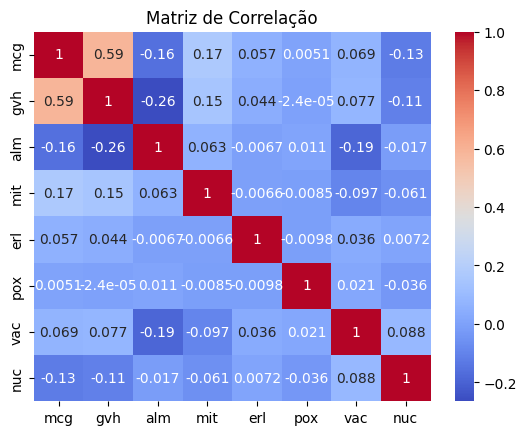

In [41]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

# Separação do dataset

In [42]:
X = df.drop(columns=['Localization site'])
y = df['Localization site']

In [43]:
X

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22
...,...,...,...,...,...,...,...,...
1413,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22
1414,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47
1415,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22
1416,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39


In [44]:
y

,Localization site
0,MIT
1,MIT
2,MIT
3,NUC
4,MIT
...,...
1413,ME2
1414,NUC
1415,ME2
1416,NUC


## Separação de treino, validação e teste

In [45]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)
X_test.to_numpy()
y_test.to_numpy()

array(['ME3', 'CYT', 'NUC', 'NUC', 'ME3', 'NUC', 'CYT', 'NUC', 'NUC',
       'CYT', 'ME3', 'MIT', 'NUC', 'MIT', 'EXC', 'NUC', 'NUC', 'NUC',
       'MIT', 'NUC', 'MIT', 'MIT', 'NUC', 'MIT', 'CYT', 'MIT', 'NUC',
       'ME2', 'NUC', 'POX', 'ME3', 'MIT', 'ME1', 'CYT', 'CYT', 'MIT',
       'ME3', 'NUC', 'NUC', 'CYT', 'NUC', 'NUC', 'ME1', 'NUC', 'CYT',
       'CYT', 'CYT', 'MIT', 'NUC', 'ME3', 'NUC', 'NUC', 'NUC', 'MIT',
       'NUC', 'NUC', 'NUC', 'NUC', 'ME1', 'CYT', 'NUC', 'CYT', 'NUC',
       'CYT', 'MIT', 'CYT', 'ME1', 'VAC', 'ME2', 'CYT', 'CYT', 'ME3',
       'MIT', 'CYT', 'MIT', 'NUC', 'CYT', 'NUC', 'ME3', 'CYT', 'CYT',
       'NUC', 'ME1', 'NUC', 'ME3', 'NUC', 'CYT', 'ME3', 'CYT', 'NUC',
       'ME1', 'NUC', 'CYT', 'NUC', 'EXC', 'CYT', 'ME2', 'MIT', 'NUC',
       'CYT', 'NUC', 'CYT', 'MIT', 'CYT', 'NUC', 'MIT', 'NUC', 'CYT',
       'ME3', 'CYT', 'CYT', 'MIT', 'POX', 'NUC', 'MIT', 'NUC', 'ME2',
       'CYT', 'CYT', 'NUC', 'ME2', 'ME3', 'CYT', 'MIT', 'NUC', 'CYT',
       'NUC', 'NUC',

In [46]:
y_temp.shape

(992,)

In [47]:
X_temp.shape

(992, 8)

In [48]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.3,
    stratify=y_temp,
    random_state=42
)
X_train.to_numpy()
y_train.to_numpy()
X_val.to_numpy()
y_val.to_numpy()

array(['MIT', 'CYT', 'MIT', 'NUC', 'NUC', 'NUC', 'ME3', 'ME3', 'CYT',
       'NUC', 'NUC', 'MIT', 'NUC', 'CYT', 'MIT', 'ME3', 'NUC', 'CYT',
       'NUC', 'MIT', 'CYT', 'ME2', 'CYT', 'NUC', 'NUC', 'ME2', 'NUC',
       'NUC', 'MIT', 'ME1', 'ME2', 'CYT', 'ME3', 'CYT', 'NUC', 'CYT',
       'MIT', 'NUC', 'CYT', 'MIT', 'NUC', 'ME1', 'NUC', 'NUC', 'CYT',
       'NUC', 'CYT', 'ME3', 'ME2', 'NUC', 'CYT', 'MIT', 'CYT', 'ME2',
       'ME3', 'MIT', 'CYT', 'NUC', 'CYT', 'POX', 'CYT', 'CYT', 'EXC',
       'CYT', 'CYT', 'CYT', 'NUC', 'CYT', 'CYT', 'CYT', 'MIT', 'MIT',
       'ME3', 'MIT', 'CYT', 'CYT', 'ME3', 'MIT', 'CYT', 'CYT', 'CYT',
       'NUC', 'ME3', 'ME3', 'MIT', 'MIT', 'CYT', 'CYT', 'ME3', 'NUC',
       'CYT', 'POX', 'ME3', 'MIT', 'MIT', 'MIT', 'MIT', 'CYT', 'ME1',
       'ME3', 'NUC', 'NUC', 'CYT', 'NUC', 'NUC', 'MIT', 'MIT', 'CYT',
       'CYT', 'MIT', 'NUC', 'CYT', 'NUC', 'CYT', 'ME3', 'EXC', 'CYT',
       'NUC', 'NUC', 'NUC', 'ME3', 'NUC', 'ME3', 'NUC', 'CYT', 'ME3',
       'ME2', 'MIT',

## Validação cruzada com GridSearch

In [49]:
params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [50]:
grid_decision = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy')
grid_decision.fit(X_val, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [51]:
grid_forest = GridSearchCV(RandomForestClassifier(), params, cv=5, scoring='accuracy')
grid_forest.fit(X_val, y_val)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [52]:
print("Melhores parâmetros do Decision Tree:", grid_decision.best_params_)
print("Melhor acurácia média do Decision Tree:", grid_decision.best_score_)

Melhores parâmetros do Decision Tree: {'max_depth': 5, 'min_samples_split': 2}
Melhor acurácia média do Decision Tree: 0.5468361581920905


In [53]:
print("Melhores parâmetros do Random Forest:", grid_forest.best_params_)
print("Melhor acurácia média do Random Forest:", grid_forest.best_score_)

Melhores parâmetros do Random Forest: {'max_depth': 7, 'min_samples_split': 10}
Melhor acurácia média do Random Forest: 0.6207344632768361


## Treinamento final e teste

In [106]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split= 3, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=5, min_samples_split=3, random_state=42)
}

In [107]:
train_sizes = np.arange(0.05, 1.00, 0.05)
precision_train, recall_train, f1_train = [], [], []
precision_test, recall_test, f1_test = [], [], []

In [108]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [115]:
all_metrics_train = {
    'Decision Tree': [],
    'Random Forest': []
}
all_metrics_test = {
    'Decision Tree': [],
    'Random Forest': []
}

for name, model in classifiers.items():
  print(f"\n=== {name} === ")
  metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
  metrics_test = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

  for size in train_sizes:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=size, test_size=1-size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    precision_train = precision_score(y_train, y_pred_train, average='macro', zero_division=0)
    recall_train = recall_score(y_train, y_pred_train, average='macro', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=0)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    precision_test = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, average='macro', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Calculate metrics and append to the lists within the dictionaries
    metrics_train['precision'].append(precision_train)
    metrics_train['recall'].append(recall_train)
    metrics_train['f1'].append(f1_train)
    metrics_train['accuracy'].append(accuracy_train)


    metrics_test['precision'].append(precision_test)
    metrics_test['recall'].append(recall_test)
    metrics_test['f1'].append(f1_test)
    metrics_test['accuracy'].append(accuracy_test)

  all_metrics_train[name].append(metrics_train)
  all_metrics_test[name].append(metrics_test)

  print(all_metrics_train)
  print(all_metrics_test)


=== Decision Tree === 
{'Decision Tree': [{'accuracy': [0.8142857142857143, 0.7801418439716312, 0.7075471698113207, 0.6996466431095406, 0.6864406779661016, 0.68, 0.6633064516129032, 0.6525573192239859, 0.6363636363636364, 0.6431593794076164, 0.6418485237483954, 0.6305882352941177, 0.6406080347448425, 0.6300403225806451, 0.6265286923800565, 0.6243386243386243, 0.6298755186721992, 0.6285266457680251, 0.6273199703043801], 'precision': [0.792989417989418, 0.7576055249686081, 0.7673177247347112, 0.5410664634706341, 0.6936371117151559, 0.5092710216359028, 0.6154460531751699, 0.6975636692741956, 0.6824520262015035, 0.685237649141315, 0.7847218936760727, 0.6160685352495913, 0.6821817102474558, 0.7643549085295754, 0.6467539815333117, 0.7775463015360022, 0.7043680281073276, 0.6004579061284827, 0.5977811765130276], 'recall': [0.7208994708994708, 0.6358352269858102, 0.6322484639016897, 0.5080616839788978, 0.7017511322668022, 0.5350482775754429, 0.4820357506237067, 0.566287860183807, 0.48716999256

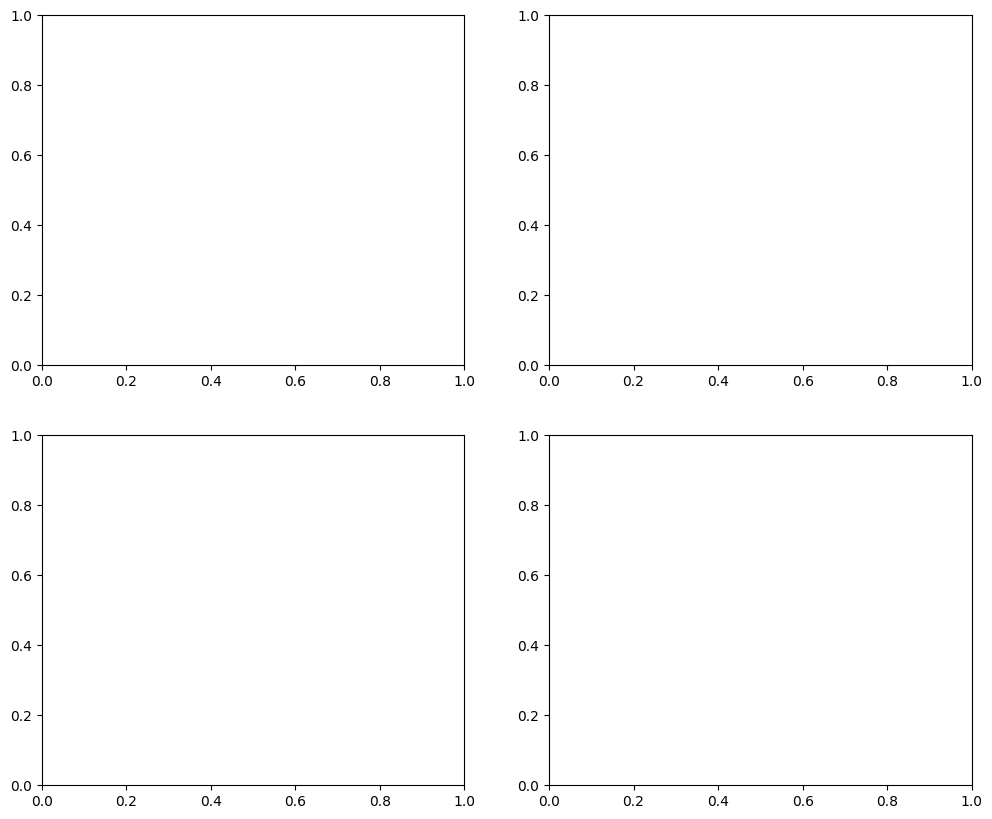

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

In [111]:
for i, metric in enumerate(metrics_train.keys()):
  axs[i].plot(train_sizes * 100, metrics_train[metric], 'o-', label='Treino')
  axs[i].plot(train_sizes * 100, metrics_test[metric], 's--', label='Teste')
  axs[i].set_title(f'{name} - {metric.capitalize()}')
  axs[i].set_xlabel('Porcentagem de Treino (%)')
  axs[i].set_ylabel(metric.capitalize())
  axs[i].legend()
  axs[i].grid(True)

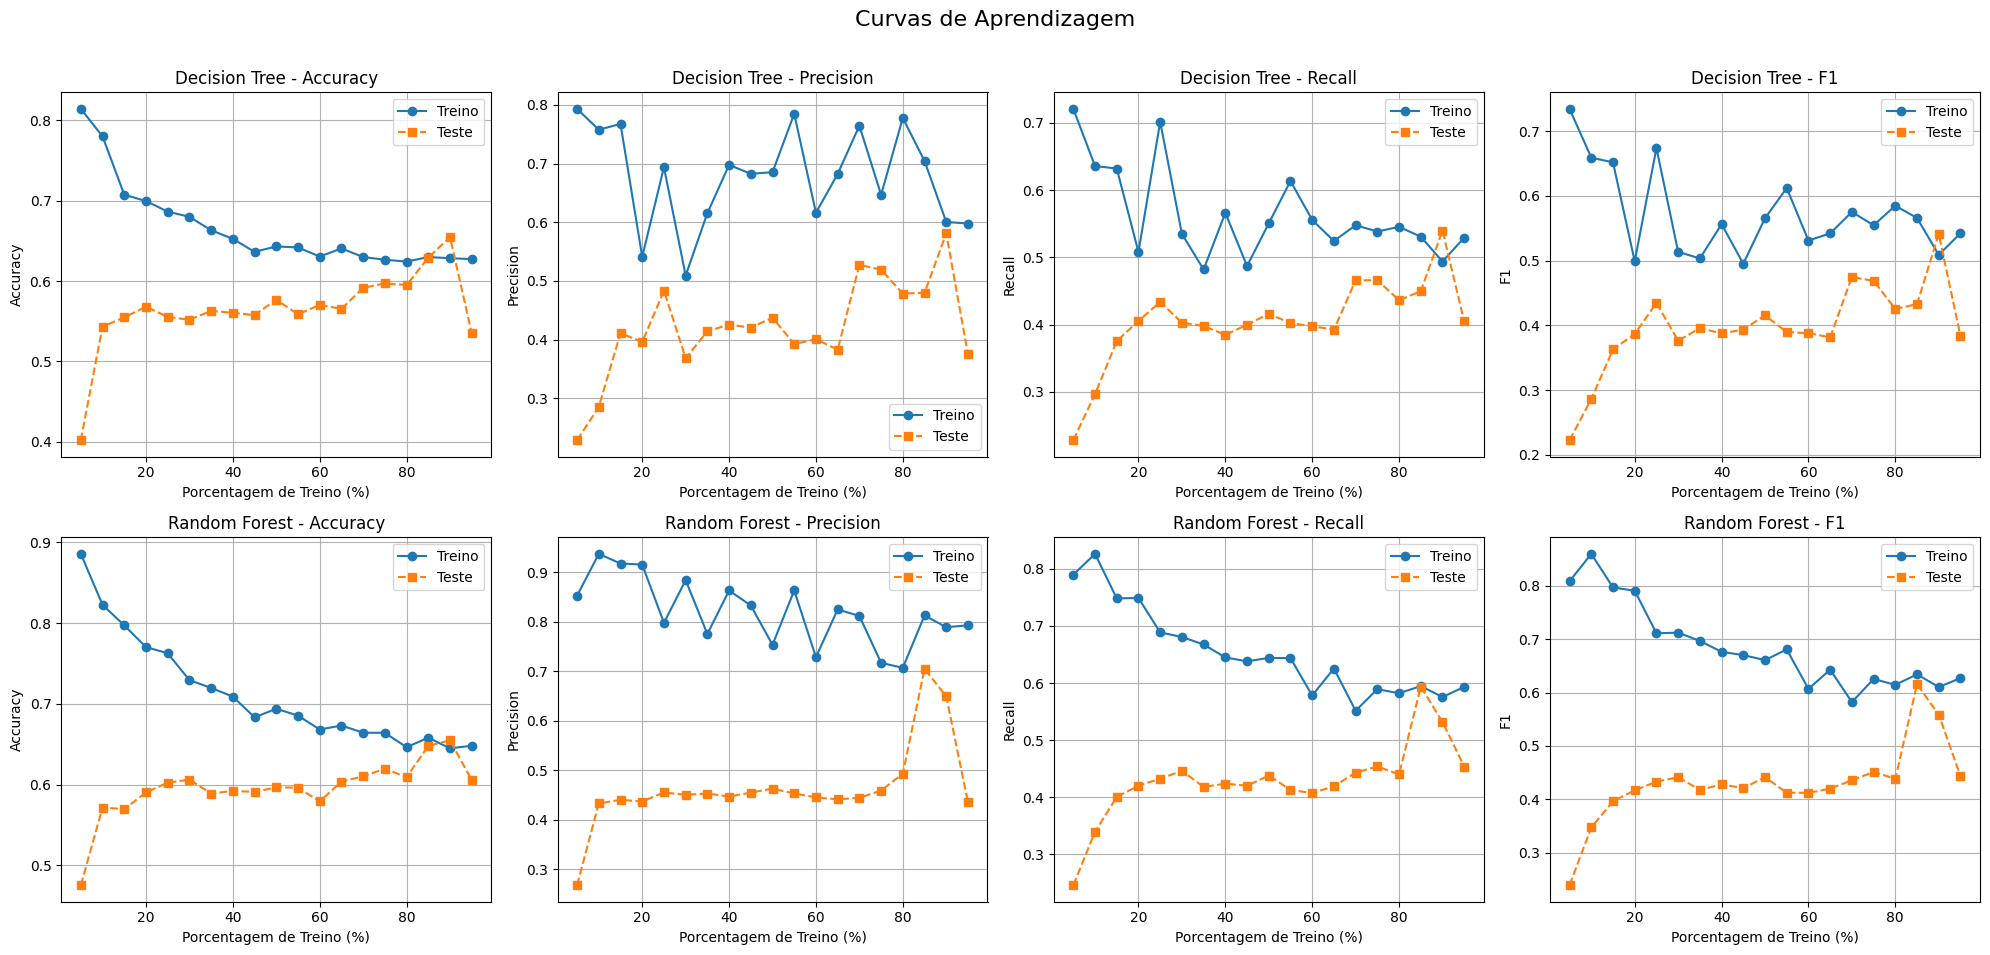

In [112]:
fig, axs = plt.subplots(len(classifiers), 4, figsize=(20, len(classifiers) * 5))
axs = axs.ravel()

for i, (name, metrics_train) in enumerate(all_metrics_train.items()):
  metrics_test = all_metrics_test[name]
  for j, metric in enumerate(metrics_train.keys()):
    axs[i * 4 + j].plot(train_sizes * 100, metrics_train[metric], 'o-', label='Treino')
    axs[i * 4 + j].plot(train_sizes * 100, metrics_test[metric], 's--', label='Teste')
    axs[i * 4 + j].set_title(f'{name} - {metric.capitalize()}')
    axs[i * 4 + j].set_xlabel('Porcentagem de Treino (%)')
    axs[i * 4 + j].set_ylabel(metric.capitalize())
    axs[i * 4 + j].legend()
    axs[i * 4 + j].grid(True)

plt.suptitle('Curvas de Aprendizagem', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [113]:
plt.suptitle(f'Curvas de Aprendizagem - {name}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 640x480 with 0 Axes>